# Aim:
We take thre samples of license plates..and try to show how the counour OCR gets impacted by difference of sizes

In [1]:
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt

# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob

import time

import math
from termcolor import colored

tess_config = "-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 --psm 6"

In [2]:
def get_image_formats(img):

    # Scales, calculates absolute values, and converts the result to 8-bit.
    plate_image = cv2.convertScaleAbs(img, alpha=(255.0))

    # convert to grayscale and blur the image
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)

    # Applied inversed thresh_binary 
    binary = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilate = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
    
    return plate_image, gray, blur, binary, dilate

In [3]:
def get_countours(plate_image, binary, dilate):
    cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # creat a copy version "test_roi" of plat_image to draw bounding box
    test_roi = plate_image.copy()

    # Initialize a list which will be used to append charater image
    crop_characters = []

    # define standard width and height of character
    digit_w, digit_h = 30, 60
    #print(len(cont))
    
    if(len(cont)>0):
        for c in sort_contours(cont):
            (x, y, w, h) = cv2.boundingRect(c)
            ratio = h/w
            if 1<=ratio<=3.5: # Only select contour with defined ratio
                if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
                    # Draw bounding box arroung digit number
                    cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

                    # Sperate number and gibe prediction
                    curr_num = dilate[y:y+h,x:x+w]
                    curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
                    _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                    crop_characters.append(curr_num)

    #print("Detect {} letters...".format(len(crop_characters)))
    #fig = plt.figure(figsize=(10,6))
    #plt.axis(False)
    #plt.imshow(test_roi)
    
    return crop_characters, test_roi
    #plt.savefig('grab_digit_contour.png',dpi=300)
                
def sort_contours(cnts,reverse = False):
        i = 0
        boundingBoxes = [cv2.boundingRect(c) for c in cnts]
        (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                            key=lambda b: b[1][i], reverse=reverse))
        return cnts

In [4]:
# Load model architecture, weight and labels
json_file = open('MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("License_character_recognition_weight.h5")
print("[INFO] Model loaded successfully...")

labels = LabelEncoder()
labels.classes_ = np.load('license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...


In [5]:
# pre-processing input images and pedict with model
def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

In [6]:
def image_contour_OCR(img):
    plate_image, gray, blur, binary, dilate = get_image_formats(img)
    
    #plt.imshow(binary,cmap="gray")
    crop_characters, test_roi = get_countours(plate_image, binary, dilate)
        
    final_string = ''
    for i,character in enumerate(crop_characters):
        #fig.add_subplot(grid[i])
        title = np.array2string(predict_from_model(character,model,labels))
        #plt.title('{}'.format(title.strip("'[]"),fontsize=20))
        final_string+=title.strip("'[]")
        #plt.axis(False)
        #plt.imshow(character,cmap='gray')
    
    return final_string, test_roi, binary
        

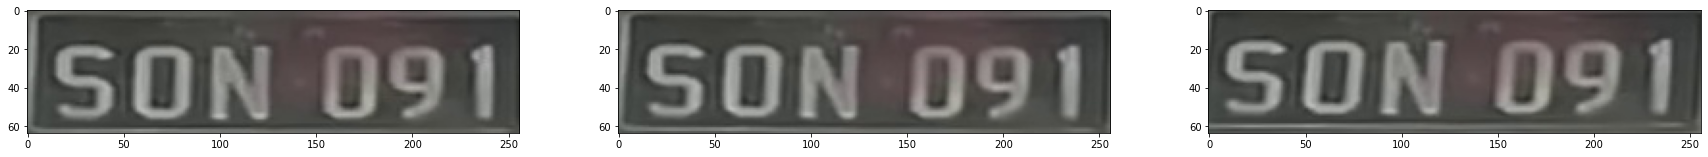

In [7]:
#img_folder_path = ('../plate_samples_110_470/*.jpg')
img_folder_path = ('../../TSK_00_MSC/wt2-body-tracker/output/Dash_cam_4/det_LpImg_crops/*.jpg')

fnames = glob.glob(img_folder_path)
fnames.sort()
#print(fnames)

cols = 3
rows = math.ceil(len(fnames)/cols)

plt.figure(figsize=(30,rows*5))
for fcnt, f in enumerate(fnames):
    img = plt.imread(f)
    plt.subplot(rows,cols,fcnt+1)    
    plt.imshow(img)
    #title = str(img.shape)
    #plt.title(title, fontsize=25 )

In [8]:
def get_allsize_contour_strings(test_image, maxw = 10, maxh = 5):
    maxw = 10
    maxh = 5

    sc = 64

    str_list = []
    size_list =[]
    test_roi_list = []
    binary_list=[]
    

    #plt.figure(figsize = (30,30))
    imcnt = 1
    for resh in range(0,maxh):
        for resw in range(maxh,maxw):

            #print(imcnt)
            ww = sc + (resw*sc)
            hh = sc + (resh*sc)
            resized_test_image = cv2.resize(test_image, (ww,hh),interpolation = cv2.INTER_AREA)
            resized_image_string, test_roi, binary= image_contour_OCR(resized_test_image.astype(np.uint8)/255)
            titlestr = str(f'{ww}x{hh} : {resized_image_string}')
            #str_list.append(resized_image_string)
            test_roi_list.append(test_roi.copy())
            binary_list.append(binary.copy())
            size_list.append(str(f'{ww}x{hh}'))
            str_list.append(resized_image_string)

            #print(f'Detected strings : {titlestr}')


            imcnt = imcnt + 1
            
    return str_list, size_list, test_roi_list, binary_list

Original img pred string : 


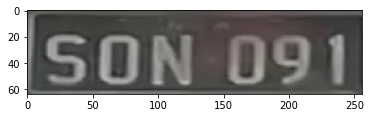

String list of various resizes


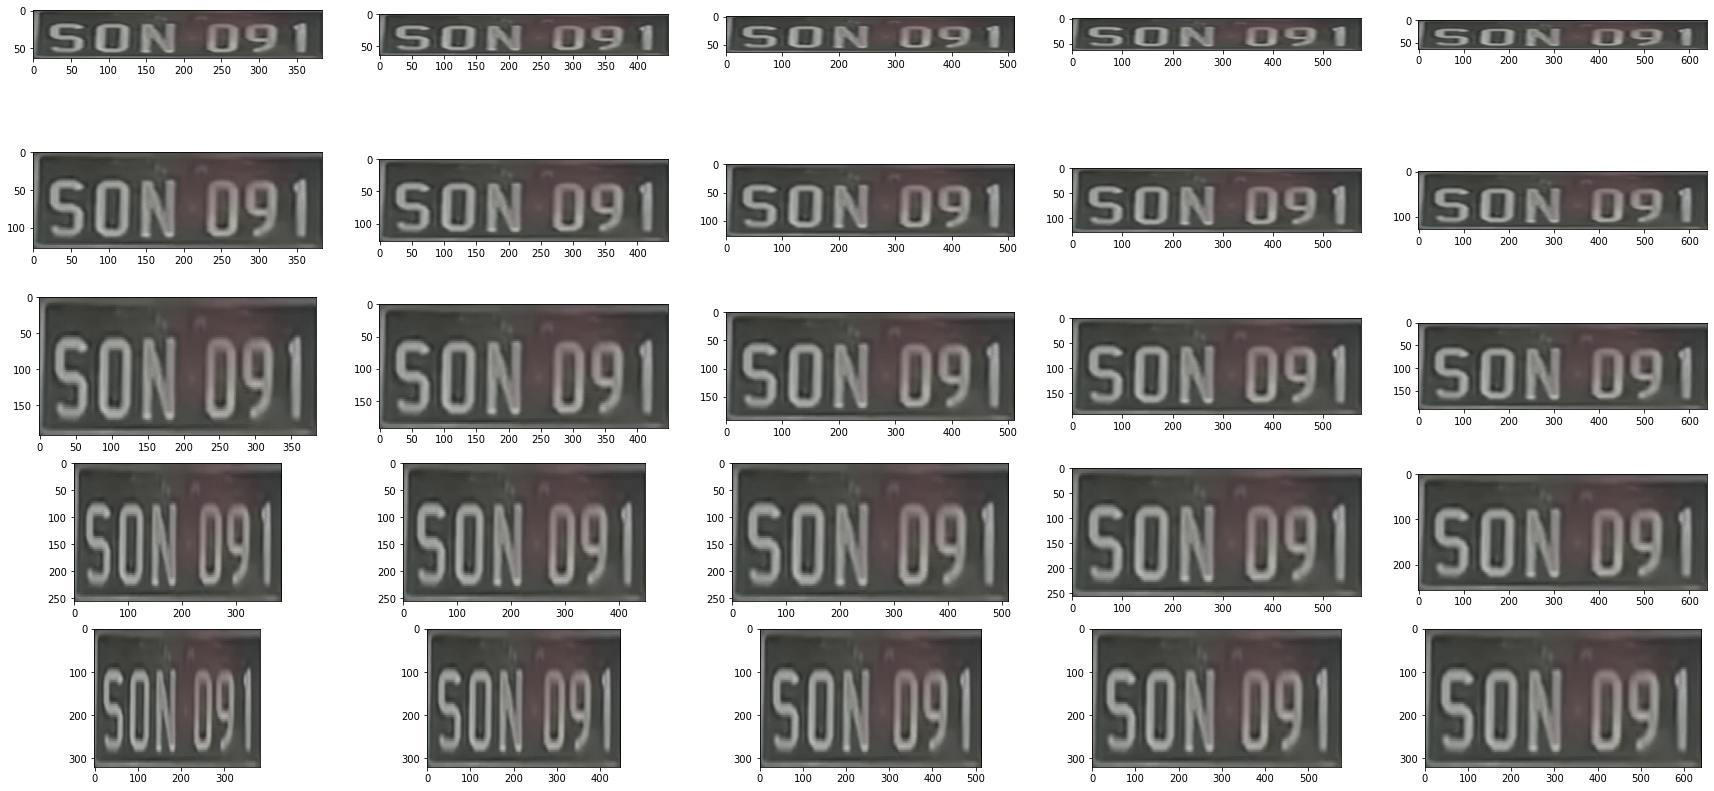

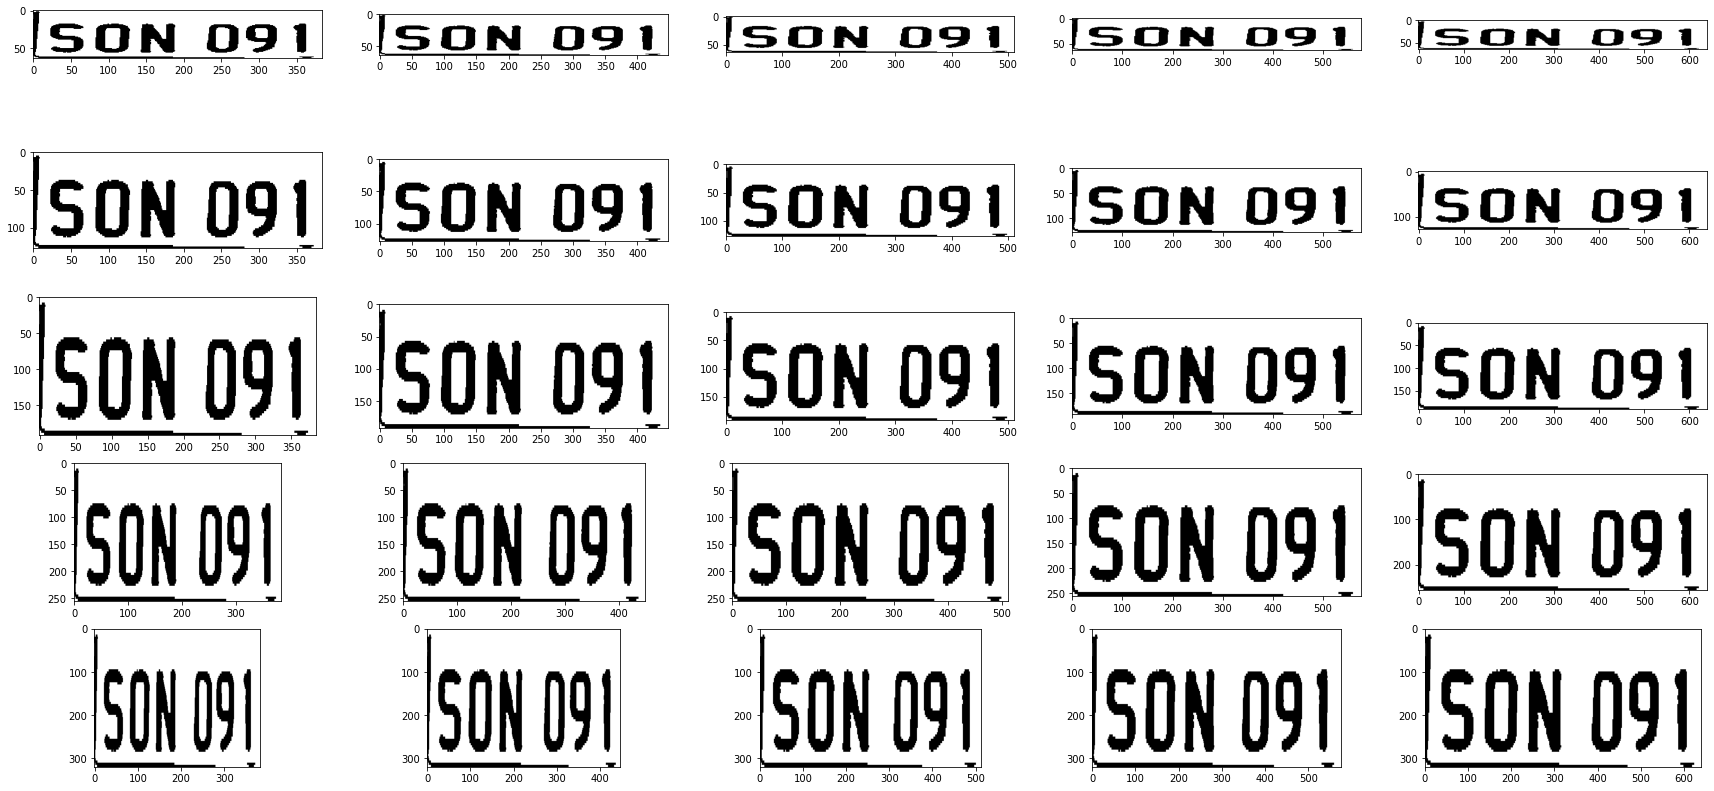

**************************************
Original img pred string : 


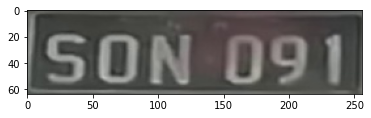

String list of various resizes


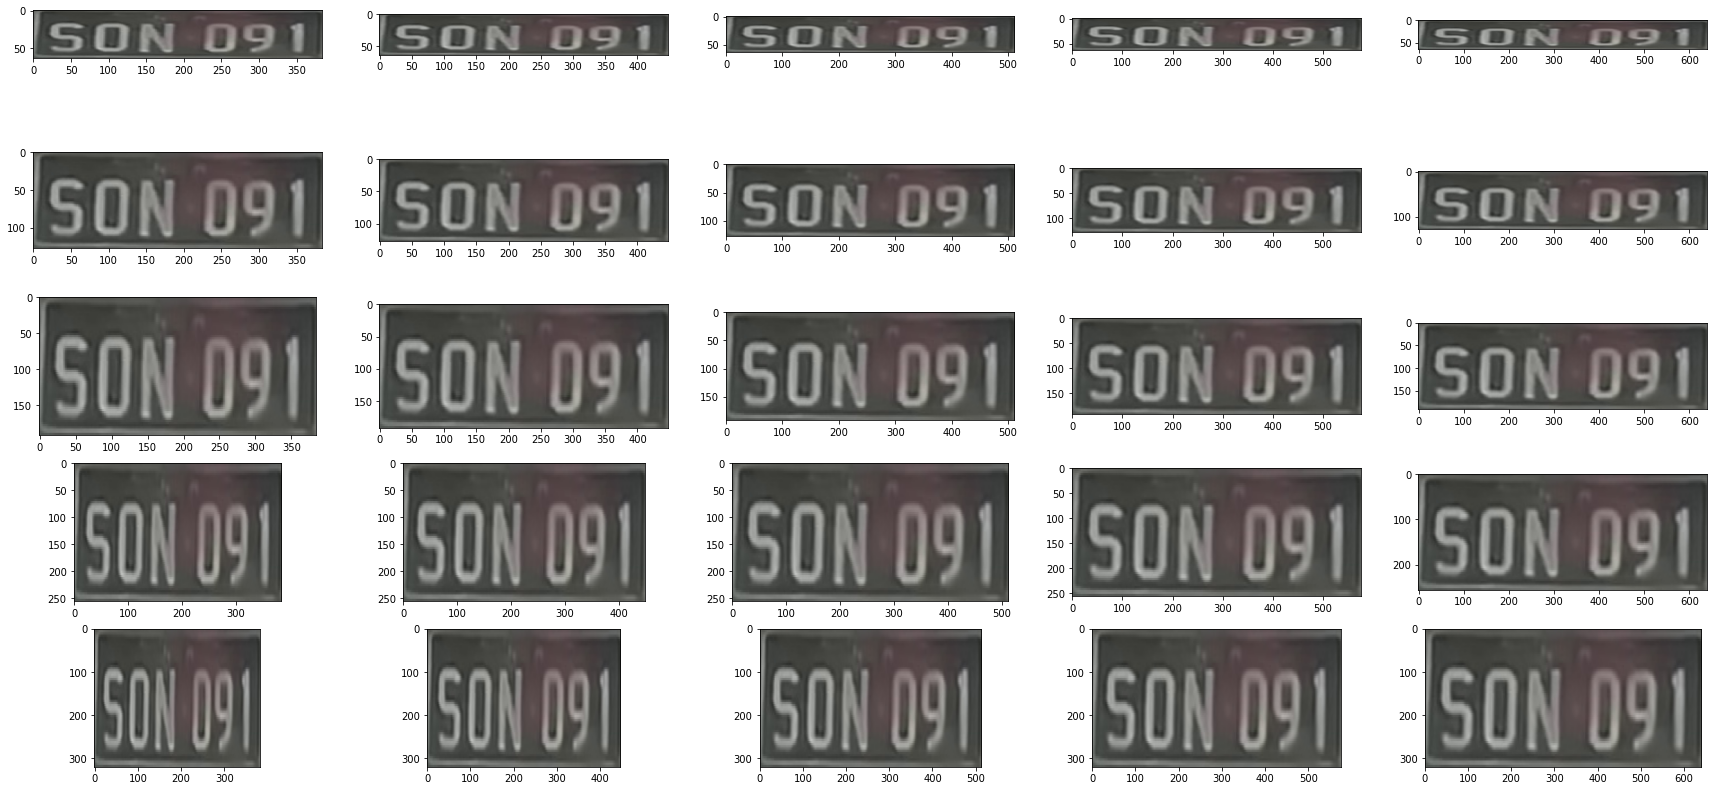

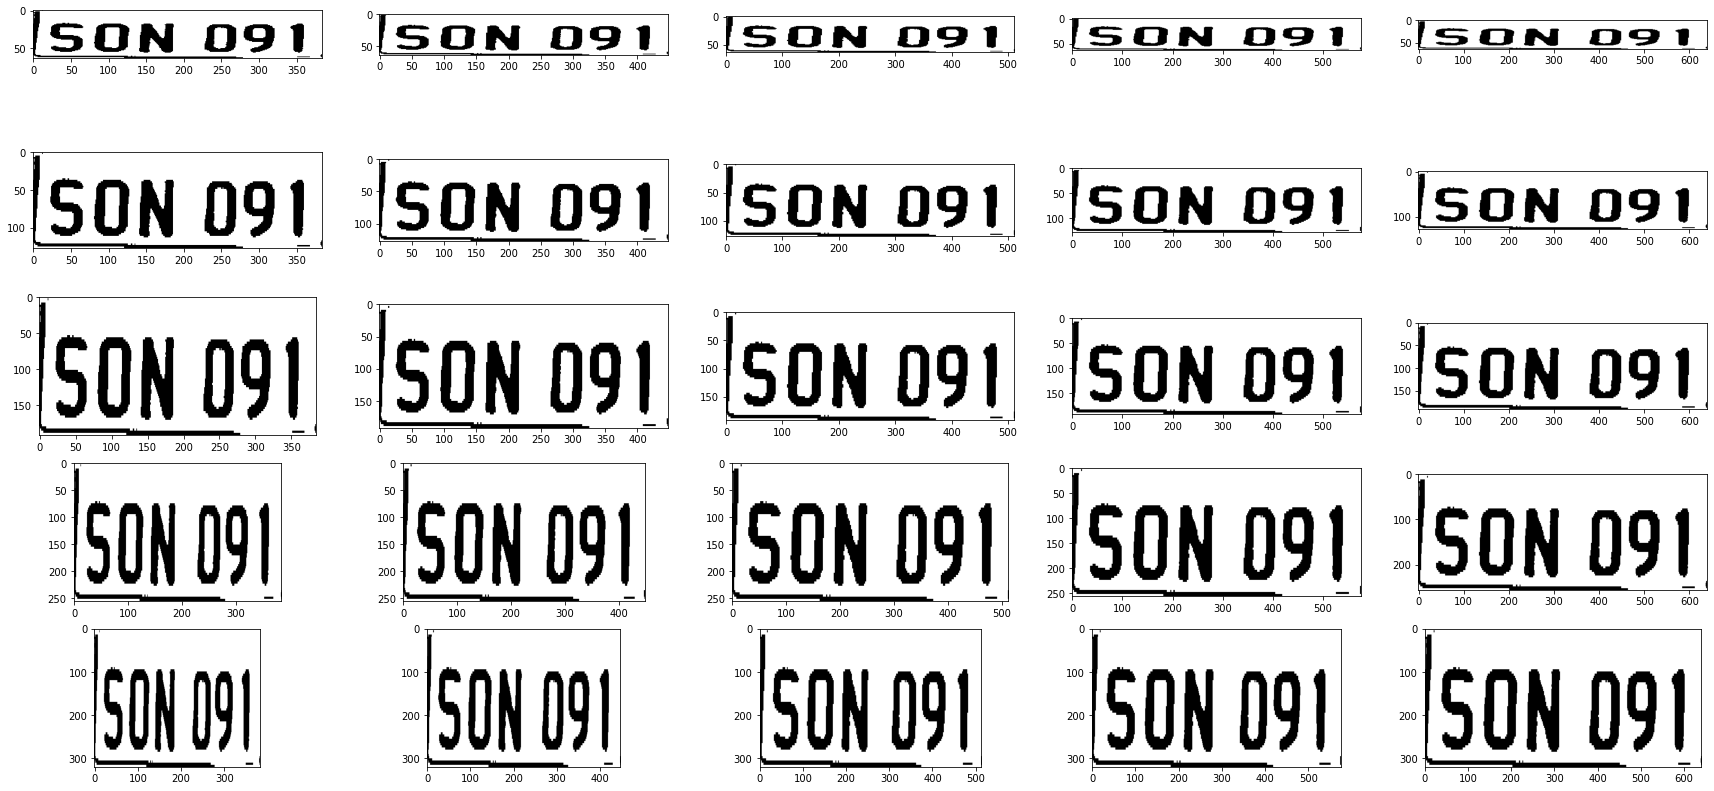

**************************************
Original img pred string : 


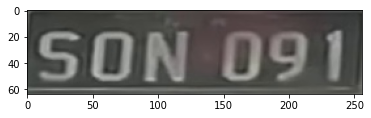

String list of various resizes


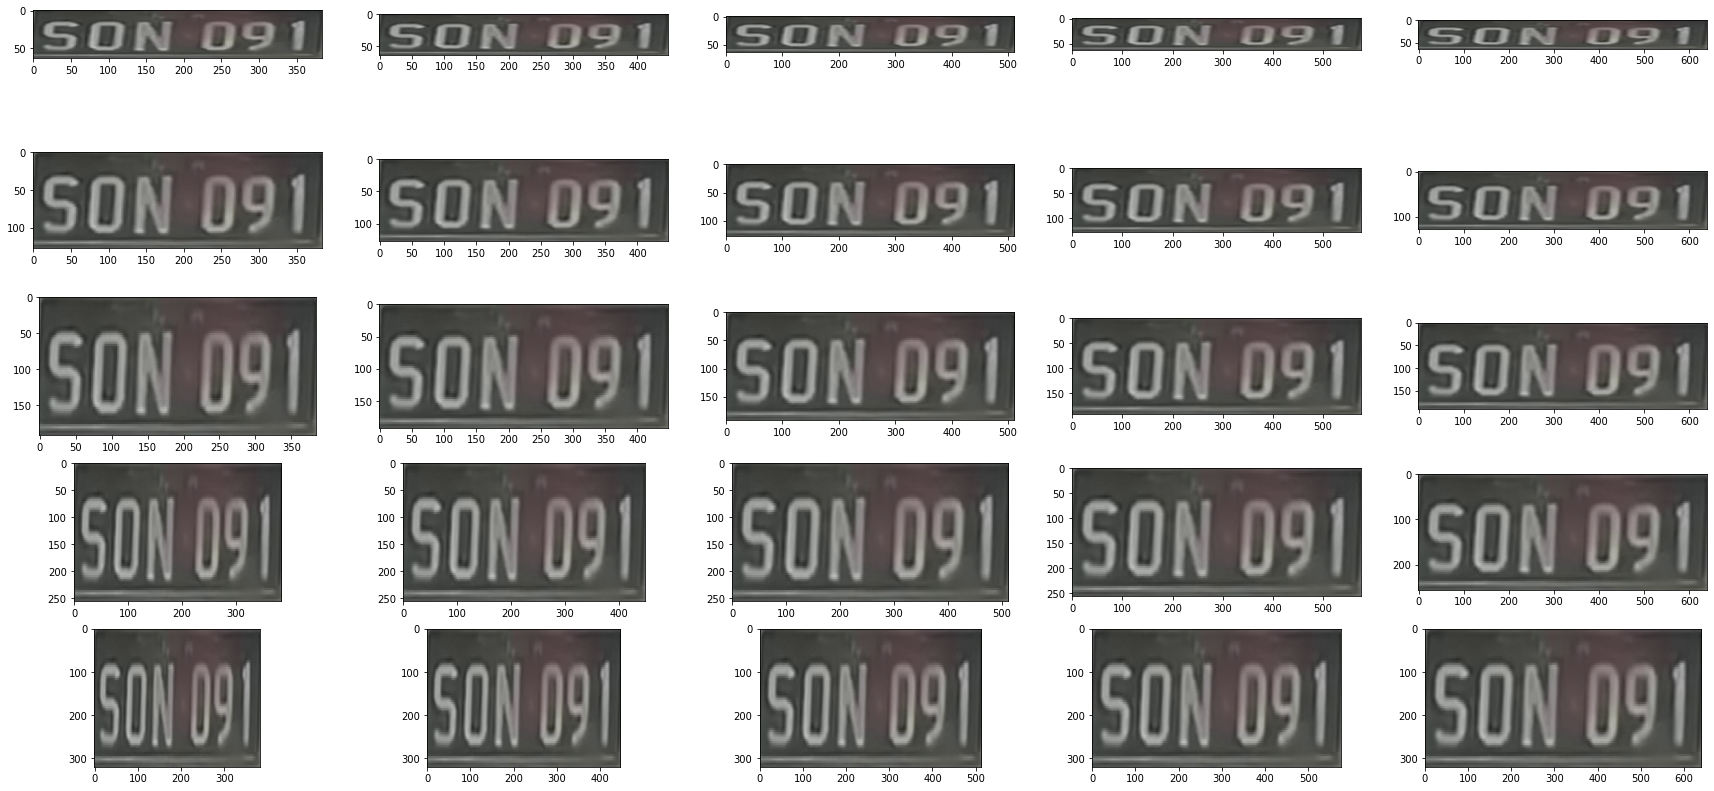

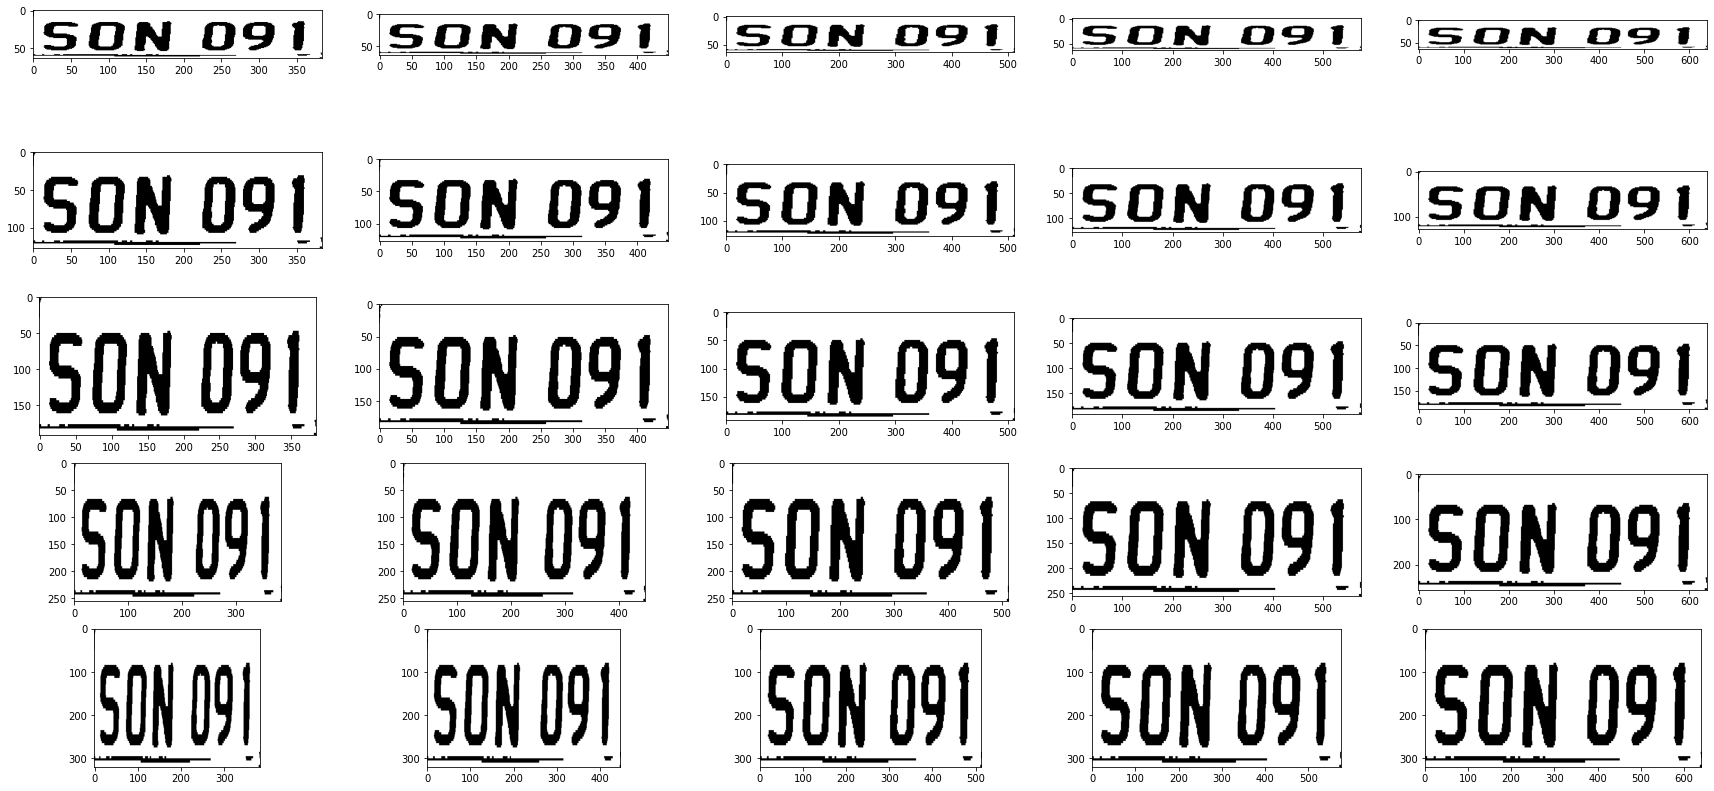

**************************************


In [9]:
start_time  = time.time()

total_img_cnt = 0
for fn_cnt, fn in enumerate(fnames):
    test_image = plt.imread(fn)
    
    test_image_string, test_roi, binary = image_contour_OCR(test_image.astype(np.uint8)/255)
    total_img_cnt = total_img_cnt + 1
    print(colored(f'Original img pred string : {test_image_string}','red'))    

    plt.figure()
    plt.imshow(test_roi)
    plt.show()
    
    maxw = 10
    maxh = 5
    
    str_list, size_list, test_roi_list, binary_list = get_allsize_contour_strings(test_image, maxw = maxw, maxh = maxh)
    total_img_cnt = total_img_cnt + len(str_list)
    
    print('String list of various resizes')
    #print(size_list)
    #print(str_list)
    
    plt.figure(figsize = (30,30))
    for test_roi_cnt, test_roi in enumerate(test_roi_list):
        plt.subplot(maxw, maxh, test_roi_cnt+1)
        plt.imshow(test_roi)
        plt.title(str_list[test_roi_cnt],fontsize=20)
    plt.show()
    
    plt.figure(figsize = (30,30))
    for test_roi_cnt, test_roi in enumerate(binary_list):
        plt.subplot(maxw, maxh, test_roi_cnt+1)
        plt.imshow(test_roi, cmap="gray")
        plt.title(str_list[test_roi_cnt],fontsize=20)
    plt.show()
        
        
    
    
    print('**************************************')    
    
end_time  = time.time()


In [10]:
print(f'Time taken : {total_img_cnt+1} images : {end_time - start_time}')
print(f'Average Time taken : 1 image : {(end_time - start_time)/(total_img_cnt+1)}')

Time taken : 79 images : 14.605417728424072
Average Time taken : 1 image : 0.1848787054230895
